Note: You can run this notebook unmodified in a local Jupyter instance, or directly from Colab:

https://colab.research.google.com/github/google/flax/blob/master/linen_examples/mnist/mnist.ipynb

In [1]:
if 'google.colab' in str(get_ipython()):
  import os
  if not os.path.isdir('flaxrepo'):
    !pip install -q ml-collections
    # Download bleeding edge Flax repo.
    !git clone --depth=1 https://github.com/google/flax flaxrepo
    !cd flaxrepo && pip install -e .
    !cp -r flaxrepo/linen_examples/mnist/* .
    import os; os._exit(0)  # Need to restart for flax package to become visible.

## Imports

In [2]:
from absl import logging
import flax
import jax.numpy as jnp
from matplotlib import pyplot as plt
import numpy as np
import tensorflow_datasets as tfds

logging.set_verbosity(logging.INFO)

In [3]:
# Helper functions.

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[..., 0], cmap='gray')
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    show_img(img, axs[i // n][i % n], title)

In [4]:
# Local imports from current directory - reload automagically.
%load_ext autoreload
%autoreload 2
import mnist_lib
from configs import default as config_lib
config = config_lib.get_config()

## Dataset

In [6]:
train_ds, test_ds = mnist_lib.get_datasets()

INFO:absl:Load dataset info from /Users/andstein/tensorflow_datasets/mnist/3.0.1
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/Users/andstein/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset for split train, from /Users/andstein/tensorflow_datasets/mnist/3.0.1
INFO:absl:Constructing tf.data.Dataset for split test, from /Users/andstein/tensorflow_datasets/mnist/3.0.1


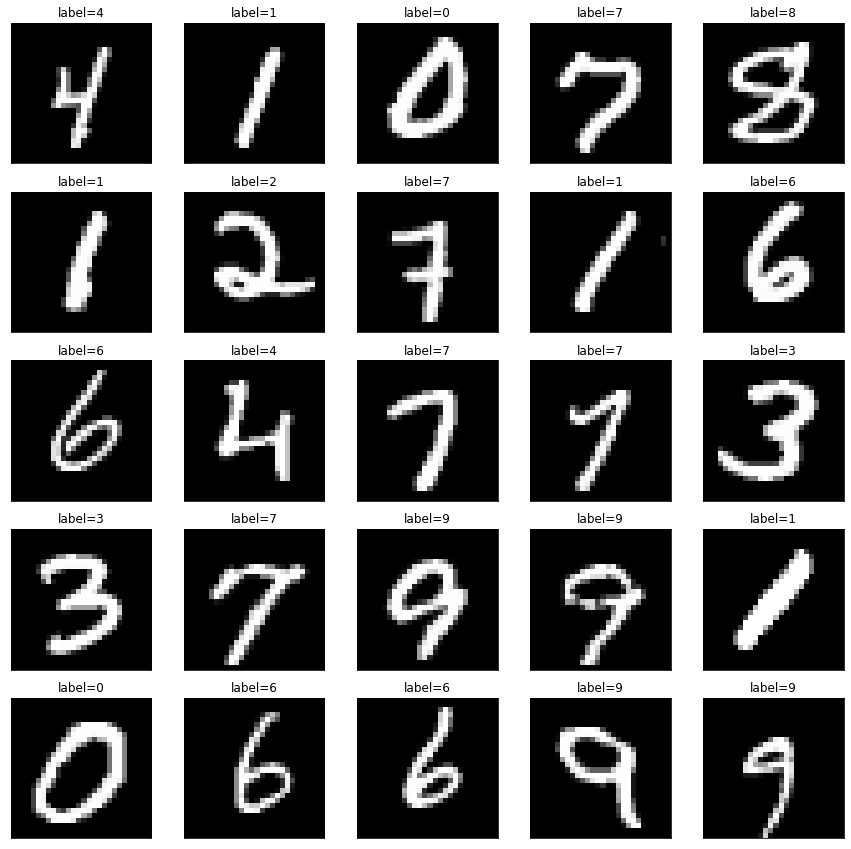

In [6]:
show_img_grid(
    [train_ds['image'][idx] for idx in range(25)],
    [f'label={train_ds["label"][idx]}' for idx in range(25)],
)

## Training

In [7]:
# Train for a single epoch.
config.num_epochs = 1
optimizer = mnist_lib.train_and_evaluate(config, model_dir='./model')

INFO:absl:Load dataset info from /Users/andstein/tensorflow_datasets/mnist/3.0.1
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/Users/andstein/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset for split train, from /Users/andstein/tensorflow_datasets/mnist/3.0.1
INFO:absl:Constructing tf.data.Dataset for split test, from /Users/andstein/tensorflow_datasets/mnist/3.0.1
INFO:absl:train epoch: 1, loss: 0.2708, accuracy: 91.90
INFO:absl:eval epoch: 1, loss: 0.0516, accuracy: 98.30


In [8]:
# Upload events to https://tensorboard.dev
if 'google.colab' in str(get_ipython()):
  !tensorboard dev upload --one_shot --logdir ./model --name 'Flax examples/mnist'

## Inference

In [9]:
# Find all mistakes in testset.
logits = mnist_lib.CNN().apply({'params': optimizer.target}, test_ds['image'])
error_idxs, = jnp.where(test_ds['label'] != logits.argmax(axis=1))
len(error_idxs) / len(logits)

0.017

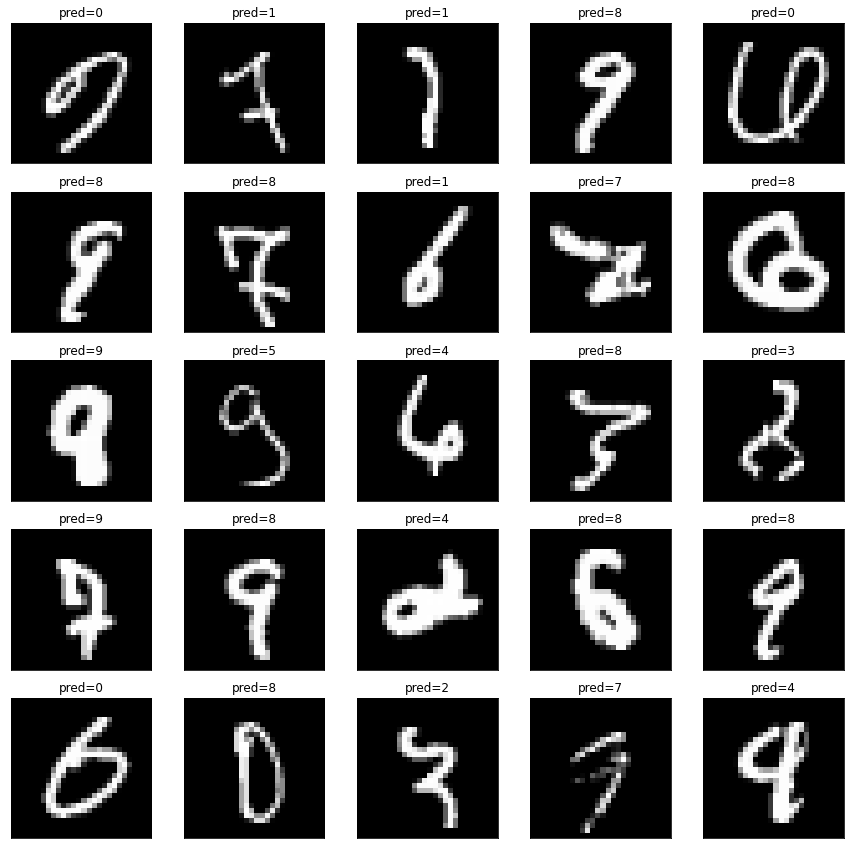

In [10]:
# Show some of them.
show_img_grid(
    [test_ds['image'][idx] for idx in error_idxs[:25]],
    [f'pred={logits[idx].argmax()}' for idx in error_idxs[:25]],
)